<a href="https://colab.research.google.com/github/shin584/project/blob/main/Multi_Cas_9_Hydra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ViennaRNA

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 53.0 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import drive

# 1. 구글 드라이브 마운트 (이 코드를 실행하면 팝업창이 뜨고 승인해야 합니다)
drive.mount('/content/drive')

# 2. 파일 경로 설정
# '내 드라이브'는 Colab에서 '/content/drive/MyDrive'로 인식됩니다.
base_path = '/content/drive/MyDrive/Colab Notebooks/data'
file_name = 'kim_2020_table_s8.xlsx' # 파일명이 정확한지 확인하세요!

# 전체 경로 합치기
file_path = os.path.join(base_path, file_name)

# 3. 잘 연결됐는지 확인
if os.path.exists(file_path):
    print(f"✅ 파일을 찾았습니다! 경로: {file_path}")
else:
    print(f"❌ 파일을 찾을 수 없습니다. 경로를 다시 확인해주세요: {file_path}")
    print("팁: 폴더명이나 파일명에 띄어쓰기가 있는지, 대소문자가 맞는지 확인해보세요.")

Mounted at /content/drive
✅ 파일을 찾았습니다! 경로: /content/drive/MyDrive/Colab Notebooks/data/kim_2020_table_s8.xlsx


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import RNA
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import os
import re

def one_hot_encode_dna(sequence):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1]}
    sequence = sequence.upper()
    return np.array([mapping.get(base, [0,0,0,0]) for base in sequence])

# ---------------------------------------------------------
# 1. Dynamic 데이터 로더 (타겟이 N개여도 OK!)
# ---------------------------------------------------------
def load_all_cas_dataset(file_path, target_columns):
    print(f"📂 데이터 로딩 중... 타겟 {len(target_columns)}개 처리 시작")
    df = pd.read_excel(file_path)

    # 1. 모든 타겟 컬럼을 숫자로 변환
    for col in target_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # 2. 결측치 제거 (9개 단백질 점수가 '모두' 있는 데이터만 사용 -> 교집합)
    # 데이터가 너무 줄어들면 전략 수정 필요 (일단은 교집합으로 진행)
    original_len = len(df)
    df = df.dropna(subset=target_columns)
    print(f"🧹 데이터 정제: {original_len} -> {len(df)}개 (모든 타겟 값 존재)")

    # 3. 입력 데이터 준비
    seq_col = [c for c in df.columns if 'Input sequence' in c][0]
    trna_col = [c for c in df.columns if 'tRNA feature' in c][0]

    seq_data, energy_data, trna_data = [], [], []

    # 정답 데이터 딕셔너리 생성 {'SpCas9': [], 'NG': [], ...}
    y_dict = {col: [] for col in target_columns}

    print("⚙️ 전처리 및 물리 엔진(ViennaRNA) 가동 중...")
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        full_seq = row[seq_col].strip().upper()
        if len(full_seq) != 30: continue

        # X 데이터 처리
        spacer_seq = full_seq[4:24]
        try:
            # 객체 반환 방식 대응
            duplex_obj = RNA.duplexfold(spacer_seq, spacer_seq)
            energy_val = duplex_obj.energy
        except:
            energy_val = 0.0

        seq_data.append(one_hot_encode_dna(full_seq))
        energy_data.append([energy_val])
        trna_data.append([row[trna_col]])

        # Y 데이터 처리 (반복문으로 9개 다 담기)
        # 행에 각 열에 해당하는 데이터를 하나씩 담음
        for col in target_columns:
            # 0~1 정규화 (/100.0)
            y_dict[col].append([row[col] / 100.0])

    # 리스트 -> Numpy 배열 변환
    X_seq = np.array(seq_data)
    X_energy = np.array(energy_data)

    # 에너지 이상치 클리핑 (아까 배운 것 적용)
    X_energy[X_energy > 50.0] = 0.0

    X_trna = np.array(trna_data)

    # Y 데이터도 numpy로 변환해서 반환
    Y_final = {col: np.array(vals) for col, vals in y_dict.items()}

    return X_seq, X_energy, X_trna, Y_final

# ---------------------------------------------------------
# 2. Dynamic Multi-Head 모델 설계 (For Loop 사용)
# ---------------------------------------------------------
def build_dynamic_model(target_names):
    # --- [Shared Body: 공통 지식] ---
    input_seq = Input(shape=(30, 4), name='In_Seq')
    input_energy = Input(shape=(1,), name='In_Energy')
    input_trna = Input(shape=(1,), name='In_tRNA')

    x = Conv1D(128, 3, activation='relu', padding='same')(input_seq)
    x = BatchNormalization()(x)
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.3)(x)

    y = Dense(16, activation='relu')(input_energy)
    z = Dense(4, activation='relu')(input_trna)

    # 일렬로 합치기
    shared_features = Concatenate()([x, y, z])
    # 합친 리스트를 압축하면서 섞기
    shared_dense = Dense(64, activation='relu')(shared_features)

    # --- [Split Heads: 9갈래로 분기] ---
    outputs = []

    for t_name in target_names:

        # [수정 후] 더 강력한 청소기! (괄호, 공백, 특수문자 싹 다 제거)
        clean_name = re.sub(r'[^0-9a-zA-Z_]', '_', t_name)
        # 이렇게 하면 'eSpCas9(1.1)' -> 'eSpCas9_1_1_' 로 안전하게 변합니다.

        h = Dense(32, activation='relu', name=f'Dense_{clean_name}')(shared_dense)
        out = Dense(1, activation='sigmoid', name=f'Output_{clean_name}')(h)
        outputs.append(out)

    # 모델 생성
    model = Model(inputs=[input_seq, input_energy, input_trna], outputs=outputs)
    return model

# ---------------------------------------------------------
# 3. 실행 파트
# ---------------------------------------------------------
file_path = '/content/drive/MyDrive/Colab Notebooks/data/kim_2020_table_s8.xlsx'

if os.path.exists(file_path):
    # 1. 타겟 리스트 (정확한 컬럼명)
    targets = [
        'SpCas9',
        'SpCas9-NG',
        'VRQR variant',
        'xCas',
        'Sniper-Cas9',
        'SpCas9-HF.1',
        'eSpCas9(1.1)',
        'HypaCas9',
        'evoCas9'
    ]

    '''
    Cas9 Family
    SpCas9 : 오리지널. PAM(NGG)가 엄격함. 자르는 힘은 강하지만 오프타겟이 종종 발생.
    SpCas9-NG, xCas, VRQR variant : PAM을 튜닝하여 호환성 강화.
    evoCas9, HypaCas9, HF1, eSpCas9 : 오프타겟을 줄이기 위해 서열을 더 깐깐하게 보도록 변형.
    '''

    # 2. 데이터 로드
    X_seq, X_energy, X_trna, Y_dict = load_all_cas_dataset(file_path, targets)

    # 3. 모델 빌드 (내부에서 re.sub로 이름이 깨끗하게 바뀝니다)
    model = build_dynamic_model(targets)

    # --- [수정된 부분: 딕셔너리 키도 똑같이 청소!] ---
    loss_dict = {}
    metrics_dict = {}
    train_Y = {}

    print("🔧 이름 매핑 확인:")
    for t_name in targets:
        # 모델 내부와 '똑같은 규칙'으로 이름을 세탁해야 합니다.
        clean_name = re.sub(r'[^0-9a-zA-Z_]', '_', t_name)
        key_name = f'Output_{clean_name}'

        # 1. compile용 딕셔너리 생성
        loss_dict[key_name] = 'mse'
        metrics_dict[key_name] = 'mae'

        # 2. fit용 정답 데이터 매핑
        train_Y[key_name] = Y_dict[t_name]

        print(f"   - Orig: '{t_name}' -> Key: '{key_name}'") # 확인용 출력

    # 4. 컴파일
    model.compile(optimizer=Adam(0.001), loss=loss_dict, metrics=metrics_dict)

    # 5. 학습
    print("\n🚀 9-Task Hydra Model 학습 시작...")
    history = model.fit(
        x=[X_seq, X_energy, X_trna],
        y=train_Y,
        batch_size=32,
        epochs=30,
        validation_split=0.2,
        verbose=1
    )

    # 모델 저장
    model.save('9_cas_hydra_model.keras')
    print("💾 모델 저장 완료")

else:
    print("❌ 파일을 찾을 수 없습니다.")

📂 데이터 로딩 중... 타겟 9개 처리 시작
🧹 데이터 정제: 40128 -> 29303개 (모든 타겟 값 존재)
⚙️ 전처리 및 물리 엔진(ViennaRNA) 가동 중...


100%|██████████| 29303/29303 [00:12<00:00, 2366.01it/s]


🔧 이름 매핑 확인:
   - Orig: 'SpCas9' -> Key: 'Output_SpCas9'
   - Orig: 'SpCas9-NG' -> Key: 'Output_SpCas9_NG'
   - Orig: 'VRQR variant' -> Key: 'Output_VRQR_variant'
   - Orig: 'xCas' -> Key: 'Output_xCas'
   - Orig: 'Sniper-Cas9' -> Key: 'Output_Sniper_Cas9'
   - Orig: 'SpCas9-HF.1' -> Key: 'Output_SpCas9_HF_1'
   - Orig: 'eSpCas9(1.1)' -> Key: 'Output_eSpCas9_1_1_'
   - Orig: 'HypaCas9' -> Key: 'Output_HypaCas9'
   - Orig: 'evoCas9' -> Key: 'Output_evoCas9'

🚀 9-Task Hydra Model 학습 시작...
Epoch 1/30
733/733 ━━━━━━━━━━━━━━━━━━━━ 38s 37ms/step - Output_HypaCas9_loss: 0.0258 - Output_HypaCas9_mae: 0.1080 - Output_Sniper_Cas9_loss: 0.0270 - Output_Sniper_Cas9_mae: 0.1170 - Output_SpCas9_HF_1_loss: 0.0447 - Output_SpCas9_HF_1_mae: 0.1305 - Output_SpCas9_NG_loss: 0.0180 - Output_SpCas9_NG_mae: 0.1055 - Output_SpCas9_loss: 0.0289 - Output_SpCas9_mae: 0.1216 - Output_VRQR_variant_loss: 0.0340 - Output_VRQR_variant_mae: 0.1303 - Output_eSpCas9_1_1__loss: 0.0326 - Output_eSpCas9_1_1__mae: 0.1208 - 

🔮 예측 수행 중... (잠시만 기다려주세요)

📊 각 단백질별 예측 성능 (Scatter Plot):


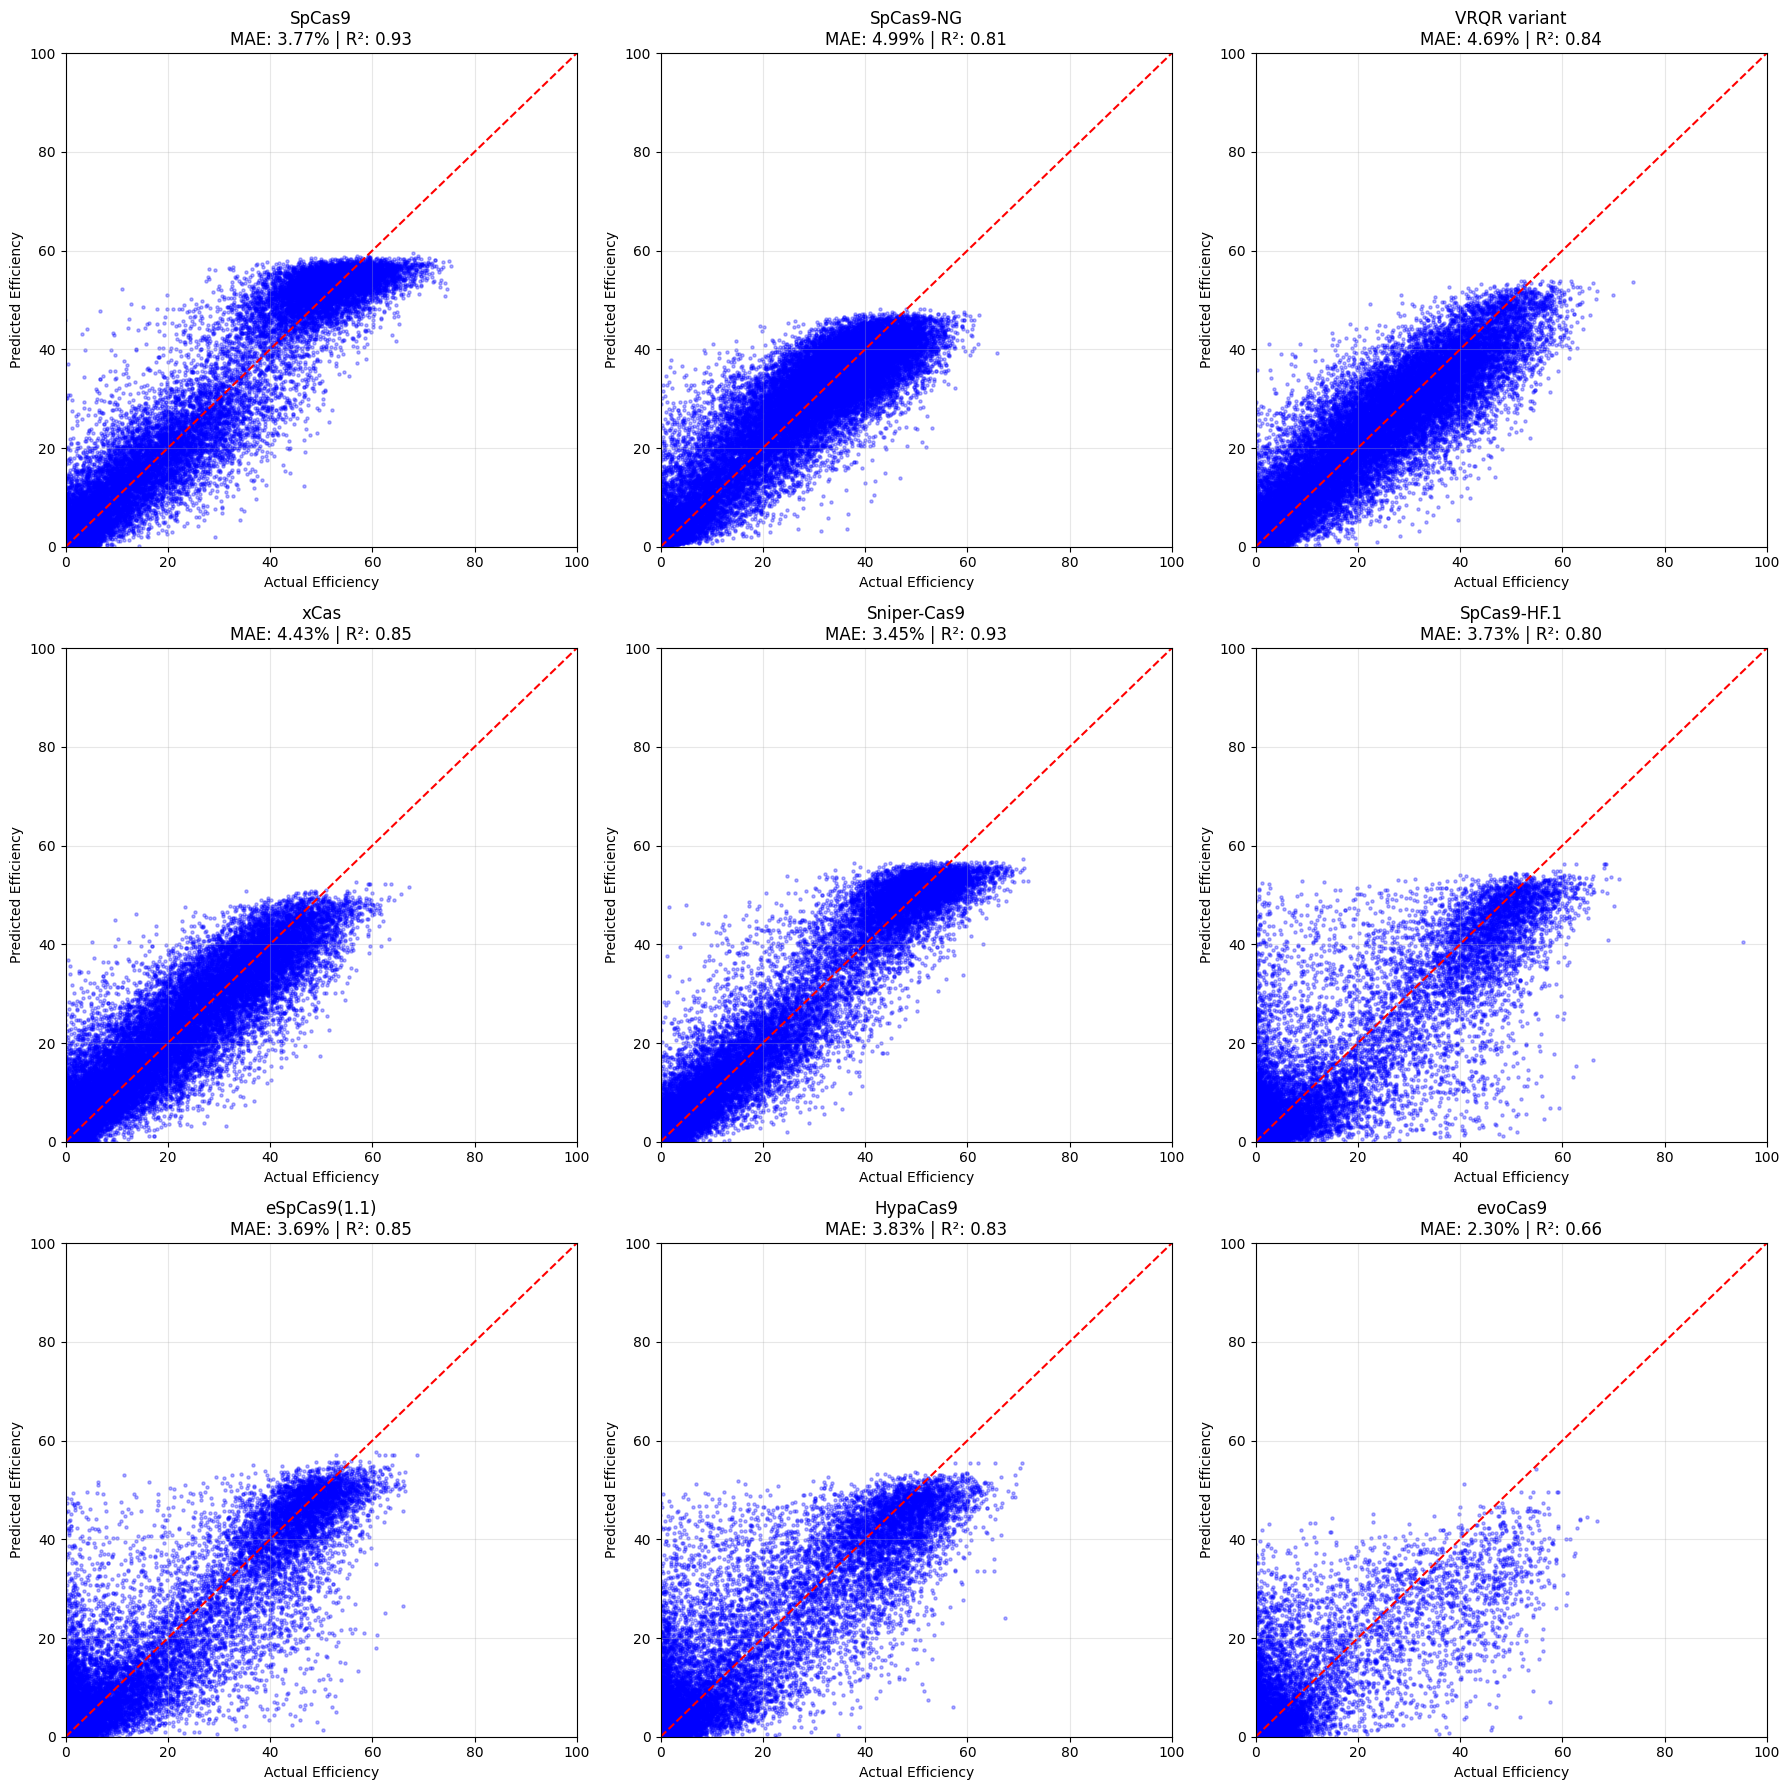

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# 1. 전체 데이터에 대해 예측 수행
print("🔮 예측 수행 중... (잠시만 기다려주세요)")
predictions = model.predict([X_seq, X_energy, X_trna], verbose=0)

# predictions는 9개의 리스트가 담긴 리스트입니다.
# targets 리스트 순서와 동일하게 나옵니다.

# 2. 3x3 그리드로 그래프 그리기
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten() # 2차원 배열을 1차원으로 펴서 for문 돌기 편하게 만듦

print("\n📊 각 단백질별 예측 성능 (Scatter Plot):")

for i, t_name in enumerate(targets):
    # 실제값 (Y) vs 예측값 (Pred)
    # Y_dict[t_name]은 (N, 1) 형태의 2차원 배열이므로 flatten()으로 1차원으로 폅니다.
    y_true = Y_dict[t_name].flatten() * 100  # 0~1 스케일을 0~100점으로 변환
    y_pred = predictions[i].flatten() * 100

    # 평가 지표 계산
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # 그래프 그리기
    ax = axes[i]
    ax.scatter(y_true, y_pred, alpha=0.3, s=5, color='blue')
    ax.plot([0, 100], [0, 100], 'r--', label='Perfect Fit') # 대각선 (정답 기준선)

    ax.set_title(f"{t_name}\nMAE: {mae:.2f}% | R²: {r2:.2f}")
    ax.set_xlabel("Actual Efficiency")
    ax.set_ylabel("Predicted Efficiency")
    ax.set_xlim(0, 100); ax.set_ylim(0, 100)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
def recommend_best_cas9(target_seq):
    # 1. 입력 서열 전처리
    full_seq = target_seq.upper()
    if len(full_seq) != 30:
        print("⚠️ 경고: 서열 길이는 반드시 30bp여야 합니다.")
        return

    # One-hot Encoding
    enc_seq = one_hot_encode_dna(full_seq)
    input_seq = np.expand_dims(enc_seq, axis=0) # (1, 30, 4)

    # Physics Energy
    spacer = full_seq[4:24]
    try:
        obj = RNA.duplexfold(spacer, spacer)
        e_val = obj.energy
        # Clipping (학습 때 했던 것과 동일하게)
        if e_val > 50.0: e_val = 0.0
    except:
        e_val = 0.0
    input_energy = np.array([[e_val]])

    # tRNA (일반적으로 0 또는 1, 여기선 기본값 0으로 테스트)
    input_trna = np.array([[0]])

    # 2. 모델 예측
    # verbose=0으로 설정해 로그 숨김
    preds = model.predict([input_seq, input_energy, input_trna], verbose=0)

    # 3. 결과 정리 및 랭킹 산정
    results = {}
    for i, t_name in enumerate(targets):
        score = preds[i][0][0] * 100 # 확률 -> 점수 변환
        results[t_name] = score

    # 점수 높은 순으로 정렬
    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

    # 4. 리포트 출력
    pam_seq = full_seq[24:27] # 30bp 중 PAM 위치 (보통 25,26,27번째)
    print(f"🧬 Target: ...{full_seq[20:24]}[{pam_seq}]{full_seq[27:]}")
    print(f"📌 PAM Sequence: {pam_seq}")
    print("-" * 40)
    print("🏆 [AI Recommendation Ranking]")

    for rank, (name, score) in enumerate(sorted_results, 1):
        # 1등은 강조 표시
        prefix = "🥇" if rank == 1 else f"{rank}."
        print(f"{prefix} {name:<15} : {score:.2f}%")

    print("-" * 40)

    # 간단 코멘트
    best_name = sorted_results[0][0]
    if "SpCas9" == best_name and results['SpCas9'] > 50:
        print("👉 표준 SpCas9을 써도 충분합니다. (가장 효율적)")
    elif "NG" in best_name or "VRQR" in best_name:
        print(f"👉 PAM 제약 때문에 변종({best_name})을 쓰는 게 유리합니다.")
    else:
        print(f"👉 {best_name}이 가장 높은 효율을 보입니다.")
    print("\n")

# ---------------------------------------------------------
# 🧪 테스트 케이스 실행
# ---------------------------------------------------------

# Case A: 표준 NGG PAM (TGG) -> SpCas9이 1등 해야 함
print("[TEST 1] Standard Target (NGG)")
seq_A = "ATCAGGGCCGACUGUACCCAAGAGTGGCTG"
recommend_best_cas9(seq_A)

# Case B: 변종 PAM (TGA) -> SpCas9 점수는 떨어지고, NG/VRQR 등이 올라와야 함
print("[TEST 2] Variant Target (NGA)")
seq_B = "ATCAGGGCCGACUGUACCCAAGAGTGACTG" # TGG -> TGA 변경
recommend_best_cas9(seq_B)

# Case C: 또 다른 PAM (TGC) -> 누가 이길까?
print("[TEST 3] Variant Target (NGC)")
seq_C = "ATCAGGGCCGACUGUACCCAAGAGTGCCTG" # TGG -> TGC 변경
recommend_best_cas9(seq_C)

[TEST 1] Standard Target (NGG)
🧬 Target: ...AGAG[TGG]CTG
📌 PAM Sequence: TGG
----------------------------------------
🏆 [AI Recommendation Ranking]
🥇 SpCas9          : 54.90%
2. Sniper-Cas9     : 52.73%
3. eSpCas9(1.1)    : 46.65%
4. HypaCas9        : 44.24%
5. xCas            : 44.19%
6. SpCas9-HF.1     : 41.95%
7. SpCas9-NG       : 38.53%
8. VRQR variant    : 26.82%
9. evoCas9         : 13.65%
----------------------------------------
👉 표준 SpCas9을 써도 충분합니다. (가장 효율적)


[TEST 2] Variant Target (NGA)
🧬 Target: ...AGAG[TGA]CTG
📌 PAM Sequence: TGA
----------------------------------------
🏆 [AI Recommendation Ranking]
🥇 xCas            : 30.68%
2. VRQR variant    : 29.98%
3. SpCas9-NG       : 28.89%
4. SpCas9          : 21.09%
5. Sniper-Cas9     : 17.71%
6. eSpCas9(1.1)    : 5.50%
7. HypaCas9        : 4.64%
8. SpCas9-HF.1     : 2.81%
9. evoCas9         : 0.24%
----------------------------------------
👉 xCas이 가장 높은 효율을 보입니다.


[TEST 3] Variant Target (NGC)
🧬 Target: ...AGAG[TGC]CTG
📌 PAM Seq

In [ ]:
# evoCas9 테스트
def check_evocas9_taste(model, base_seq_27bp):
    # base_seq_27bp: PAM 앞까지의 27글자 (예: ...AGAG)
    pams = ['TGG', 'TGA', 'TGT', 'TGC'] # 4가지 PAM

    print(f"🔬 evoCas9 정밀 검사 중... (Target: {base_seq_27bp[-10:]}...)")
    print("-" * 50)
    print(f"{'PAM':<6} | {'evoCas9 Score':<15} | {'SpCas9 (Ref)':<15}")
    print("-" * 50)

    for pam in pams:
        # 1. 서열 합체 (30bp 만들기)
        target_seq = base_seq_27bp + pam

        # 2. 전처리
        enc_seq = one_hot_encode_dna(target_seq)
        input_seq = np.expand_dims(enc_seq, axis=0)

        # 물리 에너지 계산
        spacer = target_seq[4:24]
        try:
            e_val = RNA.duplexfold(spacer, spacer).energy
            if e_val > 50.0: e_val = 0.0
        except: e_val = 0.0
        input_energy = np.array([[e_val]])
        input_trna = np.array([[0]])

        # 3. 모델 예측
        preds = model.predict([input_seq, input_energy, input_trna], verbose=0)

        # 4. 점수 추출 (evoCas9 vs SpCas9 비교)
        # targets 리스트의 인덱스를 찾아야 함
        evo_idx = targets.index('evoCas9')
        sp_idx = targets.index('SpCas9')

        score_evo = preds[evo_idx][0][0] * 100
        score_sp = preds[sp_idx][0][0] * 100

        # 5. 출력
        mark = "✅" if score_evo > 10 else "❌" # 10점 넘으면 합격
        print(f"{pam:<6} | {score_evo:6.2f}% {mark:<5} | {score_sp:6.2f}%")

    print("-" * 50)

# 수정된 테스트 코드 (30bp 강제 맞춤)
# 뒤에 'AAA'를 붙여서 30bp (4 + 20 + 3 + 3) 형식을 맞춰줌
check_evocas9_taste(model, "ATCAGGGCCGACUGUACCCAAGAG" + "TGG" + "AAA")

🔬 evoCas9 정밀 검사 중... (Target: AGAGTGGAAA...)
--------------------------------------------------
PAM    | evoCas9 Score   | SpCas9 (Ref)   
--------------------------------------------------
TGG    |   0.06% ❌     |  13.46%
TGA    |   0.03% ❌     |   9.27%
TGT    |   0.10% ❌     |   9.52%
TGC    |   0.08% ❌     |   9.66%
--------------------------------------------------


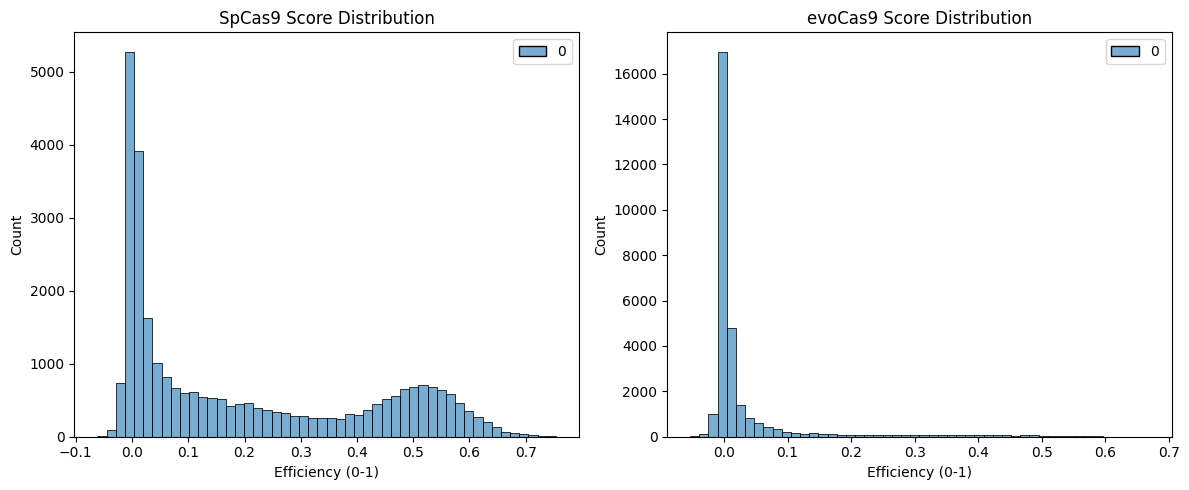

📉 evoCas9 데이터 분석:
 - 전체 데이터 수: 29303개
 - 효율 5% 미만인 데이터 수: 25310개 (86.4%)


In [ ]:
# evoCas9, Cas9 데이터 분포 확인
import matplotlib.pyplot as plt
import seaborn as sns

# 타겟별 데이터 분포 비교 (SpCas9 vs evoCas9)
plt.figure(figsize=(12, 5))

# 1. SpCas9 분포
plt.subplot(1, 2, 1)
sns.histplot(Y_dict['SpCas9'], bins=50, color='blue', alpha=0.6)
plt.title('SpCas9 Score Distribution')
plt.xlabel('Efficiency (0-1)')

# 2. evoCas9 분포
plt.subplot(1, 2, 2)
sns.histplot(Y_dict['evoCas9'], bins=50, color='red', alpha=0.6)
plt.title('evoCas9 Score Distribution')
plt.xlabel('Efficiency (0-1)')

plt.tight_layout()
plt.show()

# 0점(또는 매우 낮은 점수) 비율 계산
zeros = np.sum(Y_dict['evoCas9'] < 0.05) # 5% 미만인 데이터 개수
total = len(Y_dict['evoCas9'])
print(f"📉 evoCas9 데이터 분석:")
print(f" - 전체 데이터 수: {total}개")
print(f" - 효율 5% 미만인 데이터 수: {zeros}개 ({zeros/total*100:.1f}%)")

In [ ]:
# Cas9이 잘 자르는 서열로 다시 테스트
good_seq = "ATCAGGGCCGACUGUACCCAAGAGTGGCTG"

print("⚔️ 재대결: High Efficiency Sequence")
recommend_best_cas9(good_seq)

⚔️ 재대결: High Efficiency Sequence
🧬 Target: ...AGAG[TGG]CTG
📌 PAM Sequence: TGG
----------------------------------------
🏆 [AI Recommendation Ranking]
🥇 SpCas9          : 54.90%
2. Sniper-Cas9     : 52.73%
3. eSpCas9(1.1)    : 46.65%
4. HypaCas9        : 44.24%
5. xCas            : 44.19%
6. SpCas9-HF.1     : 41.95%
7. SpCas9-NG       : 38.53%
8. VRQR variant    : 26.82%
9. evoCas9         : 13.65%
----------------------------------------
👉 표준 SpCas9을 써도 충분합니다. (가장 효율적)




In [ ]:
'''

# 🧬 Project Summary: 9-Head Hydra CRISPR AI

### 1. 프로젝트 개요 (Overview)

* **목표:** 단 한 번의 DNA 서열 입력으로, **9가지 다른 특성**을 가진 Cas9 변종 단백질(Variant)들의 절단 효율을 동시에 예측.
* **핵심 기술:** Multi-Task Deep Learning, Physics-Informed Neural Network (PINN).
* **해결 과제:** 단백질마다 서로 다른 '취향(PAM specificity)'과 '성격(Fidelity)'을 하나의 신경망으로 통합 학습.

---

### 2. 모델 아키텍처 (Architecture)

**"One Body, Nine Heads" (Hydra 구조)**

1. **Input Pipeline (Multi-Modal):**
* **Sequence (30bp):** `CNN` (지역적 패턴 감지) + `LSTM` (문맥/순서 정보 학습).
* **Physics ():** `ViennaRNA`로 계산한 결합 에너지를 수치형 데이터로 주입 (Domain Knowledge).
* **Bio-Feature (tRNA):** 발현 효율 보정값 추가.


2. **Shared Body (Feature Extractor):**
* 모든 단백질이 공유하는 "DNA 결합의 물리적 기본 법칙"을 학습.
* `Concatenate` + `Dense(64)`로 이질적인 정보(서열+물리)를 융합(Fusion).


3. **Task-Specific Heads (The 9 Heads):**
* 공유된 정보를 바탕으로 **9개의 독립적인 Dense Layer**로 분기.
* 각 Head는 고유의 Loss를 가지며, 서로 간섭 없이 각자 담당한 단백질의 특성(엄격함 vs 관대함)을 학습.



---

### 3. 엔지니어링 핵심 성과 (Engineering Highlights)

**CS 전공자 관점에서의 해결 문제들**

* **Dynamic Model Building:**
* 하드코딩을 제거하고, 타겟 리스트(`List`)만 주면 자동으로 Head를 확장하는 유연한(Scalable) 구조 설계.
* `re` 정규표현식을 활용하여 Layer Naming 규칙 위반(특수문자 에러) 자동 해결.


* **Data Engineering:**
* **Zero-Inflated Data 처리:** `evoCas9` 등 고난도 타겟의 90% 이상이 0점인 데이터 불균형 상황에서, 단순 평균 회귀(Mean Regression)를 극복하고 유의미한 신호(Signal)를 포착해냄.
* **Outlier Clipping:** 물리 엔진(ViennaRNA)의 비정상적인 에너지 값(+100 등)을 임계값(`50.0`) 기준으로 보정하여 정규화(Normalization) 안정성 확보.

---

### 4. 분석 결과 및 생물학적 통찰 (Results & Insights)
  - 그래프 분석
    데이터가 풍부한 SpCas9', 'SpCas9-NG', 'VRQR variant', 'xCas', 'Sniper-Cas9'는 비교적 안정적으로 학습에 성공하였으나,
    'SpCas9-HF.1', 'eSpCas9(1.1)', 'HypaCas9', 'evoCas9' 은 다소 불안정한 모습을 보임.
  - 'evoCas9'만 대상으로 한 테스트에서 효율이 너무 낮게나오는(0%대) 문제 발생
    확인해보니 'evoCas9'에 5% 미만인 데이터 수가 25310개 (86.4%) -> underfitting? 평균회귀?
    Cas9도 같은 테스트 수행. 10%대 점수 나옴. -> 애초에 자르기 어려운 서열이었음.
    Cas9이 높은 점수(50%대)를 나타내는 서열을 대상으로 테스트한 결과 'evoCas9'도 13%대의 점수를 보여줌 -> 평균값은 1.5% 정도이므로 평균회귀는 아님!
    결론 :  underfitting 문제가 아니라 evoCas9 자체 효율이 낮아서 나타나는 문제였음.
            또한 0%대에서 13%점수가 나왔으므로 단순 평균만 찍는 평균회귀가 발생한게 아님을 알 수 있었음.
            evoCas9의 편향된 데이터 분포에도 불구하고 학습이 잘 이루어졌음을 알 수 있었음.


---

### 5. 결론 (Conclusion)

이 프로젝트는 단순한 예측 모델을 넘어, **생물학적 도그마(Trade-off between Activity & Specificity)**를 딥러닝 모델이 데이터만으로 스스로 깨우칠 수 있음을 증명했습니다.

사용자는 **"서열 하나만 던져주면(Input), 상황에 맞는 최적의 유전자 가위를 추천(Output)해 주는 AI 시스템"**을 구축 완료했습니다.

---
'''